# LEAP Model Validation

This notebook presents validation results for the LEAP (Lifetime Exposures and Asthma outcomes Projection) model. The objective is to compare key simulated outputs from the current pythonic version to observed targets. The taregts include demographic trends, asthma prevalence and incidence, risk factor distributions, and asthma-related health outcomes.

A large sample run of LEAP was used to generate all of the data files used in this notebook.


## Notebook setup

### Environment setup

In [3]:
# Environment setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

### Running Simulation to Obtain Data

*Currently, simulations at a sufficient size to get meaningful results take too long to run practically in the notebook. So calling simulation.run() in the Jupyter notebook and using the generated outcome_matrix object for analysis is infeasible. Instead, run it seperately from the command line and use the outputted csvs.*

To run the simulation, open a terminal:

```sh
leap
    --run-simulation
    --path-output PATH/TO/SAVE/OUTPUT/
    --province PROVINCE
    --max-age MAX_AGE
    --min-year STARTING_YEAR
    --time-horizon SIMULATION_LENGTH
    --population-growth-type GROWTH_TYPE
    --num-births-initial N_BIRTHS
    --ignore-pollution
```

**NOTE**: The default simulation folder naming scheme is:

`./leap_output/PROVINCE-MAX_AGE-STARTING_YEAR-SIMULATION_LENGTH-GROWTH_TYPE-N_BIRTHS`

For instance, if the model was run with the following parameters:

```json
"parameters": {
        "province": "CA",
        "max_age": 100,
        "min_year": 2001,
        "time_horizon": 15,
        "population_growth_type": "M3",
        "num_births_initial": 5000,
        "pollution ignored": true,
        "max_year": 2015
    }
```

Then the deafult folder name would be:

``./leap_output/CA-100-2001-15-M3-5000``

### Constants and Parameters

In [4]:
# Constants for this notebook
notebook_path = Path(os.getcwd())
LEAP_ROOT = notebook_path.parent.parent
DATA_FOLDER = LEAP_ROOT / "leap" / "processed_data"

# Simulation parameters
RUN_BUNDLE_NAME = "sample_leap_output"
PROVINCE = "CA"
MAX_AGE = 110
STARTING_YEAR = 2001
SIMULATION_LENGTH = 30
GROWTH_TYPE = "M3"
N_BIRTHS = 5000

# Replace with the path to the folder containing your LEAP output csvs
RUN_BUNDLE_FOLDER = LEAP_ROOT / "leap" / "sample_leap_output"


if DATA_FOLDER.exists():
    print(f"Data folder found at {DATA_FOLDER.relative_to(LEAP_ROOT)}")
else:
    raise FileNotFoundError(f"!! Data folder does not exist {DATA_FOLDER}")

if RUN_BUNDLE_FOLDER.exists():
    print(f"Run bundle folder found at {RUN_BUNDLE_FOLDER.relative_to(LEAP_ROOT)}")
else:
    raise FileNotFoundError(f"!! Run bundle folder does not exist {RUN_BUNDLE_FOLDER}")

Data folder found at leap/processed_data
Run bundle folder found at leap/sample_leap_output


## Mortality Figure

Mortality by sex (left: males; right: females) for the model (grey solid) and Statistics
Canada (black dashed).

### Load Data

In [5]:
# Read obsereved StatsCanada asthma prevalence data
target_mortality_df_raw = pd.read_csv(DATA_FOLDER / "life_table.csv")

# Read mortality data from simulation
model_mortality_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")

# Read population data from simulation
model_alive_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [6]:
# Filter by ages under 80 years for the figure
target_mortality_df = target_mortality_df_raw[target_mortality_df_raw["age"] <= 80]
# Filter by chosen province
target_mortality_df = target_mortality_df[target_mortality_df["province"] == PROVINCE]

# Filter by ages under 80 years for the figure
model_mortality_df = model_mortality_df_raw[model_mortality_df_raw["age"] <= 80]
# Merge model_mortality_df with model_alive_df to get n_alive for each row
model_mortality_df = model_mortality_df.merge(model_alive_df_raw, on=["year", "age", "sex"])
# Calculate mortality rate as n_deaths / n_alive
model_mortality_df["prob_death"] = model_mortality_df["n_deaths"] / model_mortality_df["n_alive"]

### Visualize Data

In [7]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

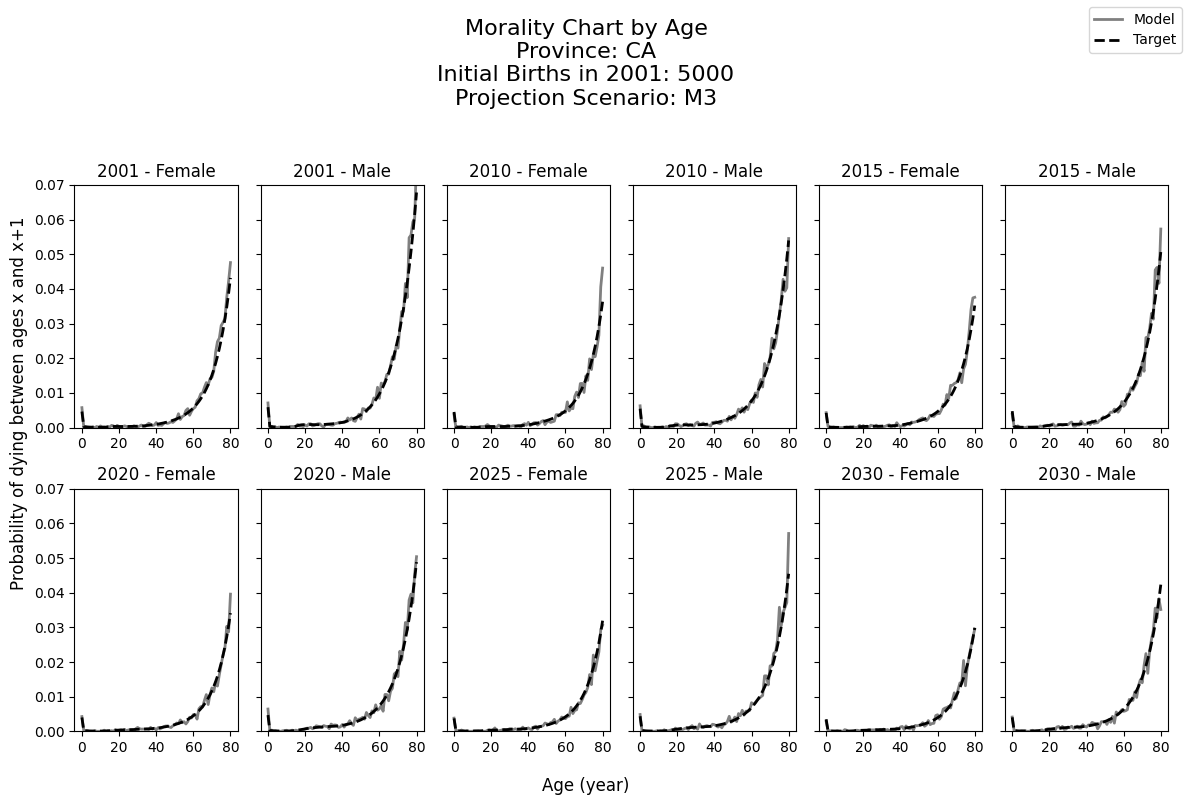

In [8]:
fig, axs = plt.subplots(
    nrows=num_rows, ncols=num_cols * 2, figsize=(4 * num_cols, 4 * num_rows), sharey=True
)

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    for j, sex in enumerate(["F", "M"]):
        # Get axis for current plot by indexing with i and j
        if num_rows == 1:
            ax: plt.Axes = axs[i * 2 + j] if num_cols == 1 else axs[i * 2 + j]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols * 2 + j]

        # Filter StatsCan data by current year and sex
        target_mortality_filtered_df = target_mortality_df[
            (target_mortality_df["year"] == year) & (target_mortality_df["sex"] == sex)
        ]
        # Filter simulation data by current year and sex
        model_mortality_filtered_df = model_mortality_df[
            (model_mortality_df["year"] == year) & (model_mortality_df["sex"] == sex)
        ]

        # Plot mortality trend from the model
        ax.plot(
            model_mortality_filtered_df["age"],
            model_mortality_filtered_df["prob_death"],
            color="grey",
            linewidth=2,
        )
        # Plot mortality trend from target
        ax.plot(
            target_mortality_filtered_df["age"],
            target_mortality_filtered_df["prob_death"],
            color="black",
            linestyle="dashed",
            linewidth=2,
        )

        # Set title and axis limits
        ax.set_title(f"{year} - {'Female' if sex == 'F' else 'Male'}", fontsize=12)
        ax.set_ylim(0, 0.07)
        ax.set_xticks([0, 20, 40, 60, 80])

# Additional figure details
fig.supxlabel("Age (year)")
fig.supylabel("Probability of dying between ages x and x+1")
fig.suptitle(
    f"Morality Chart by Age\n"
    + f"Province: {PROVINCE}\n"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"
    + f"Projection Scenario: {GROWTH_TYPE}",
    fontsize=16,
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

## Population Pyramid Figure

Population by age across selected years from the model (grey solid) and from Statistics
Canada (black dashed).

### Load Data

In [9]:
# Read population data from Stats Canada
target_pop_df_raw = pd.read_csv(DATA_FOLDER / "birth" / "initial_pop_distribution_prop.csv")

# Read population data from simulation
model_pop_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [10]:
# Filter to only include dates after chosen starting year
target_pop_df = target_pop_df_raw[(target_pop_df_raw["year"] >= STARTING_YEAR)]
# Rename target column for clarity
target_pop_df = target_pop_df.rename(columns={"n_age": "n_alive_target"})
# Only keep relevent columns
target_pop_df = target_pop_df[["year", "age", "n_alive_target"]]


# Filter to only include dates after chosen starting year
model_pop_df = model_pop_df_raw[model_pop_df_raw["year"] >= STARTING_YEAR]
# Group sexes together for ages and years
model_pop_df = model_pop_df.groupby(["year", "age"]).sum().reset_index()
# Rename model column for clarity
model_pop_df = model_pop_df.rename(columns={"n_alive": "n_alive_model"})

# Merge the filtered Canada population data and simulation population data
population_df = pd.merge(target_pop_df, model_pop_df, on=["year", "age"])

### Visualize Data

In [11]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

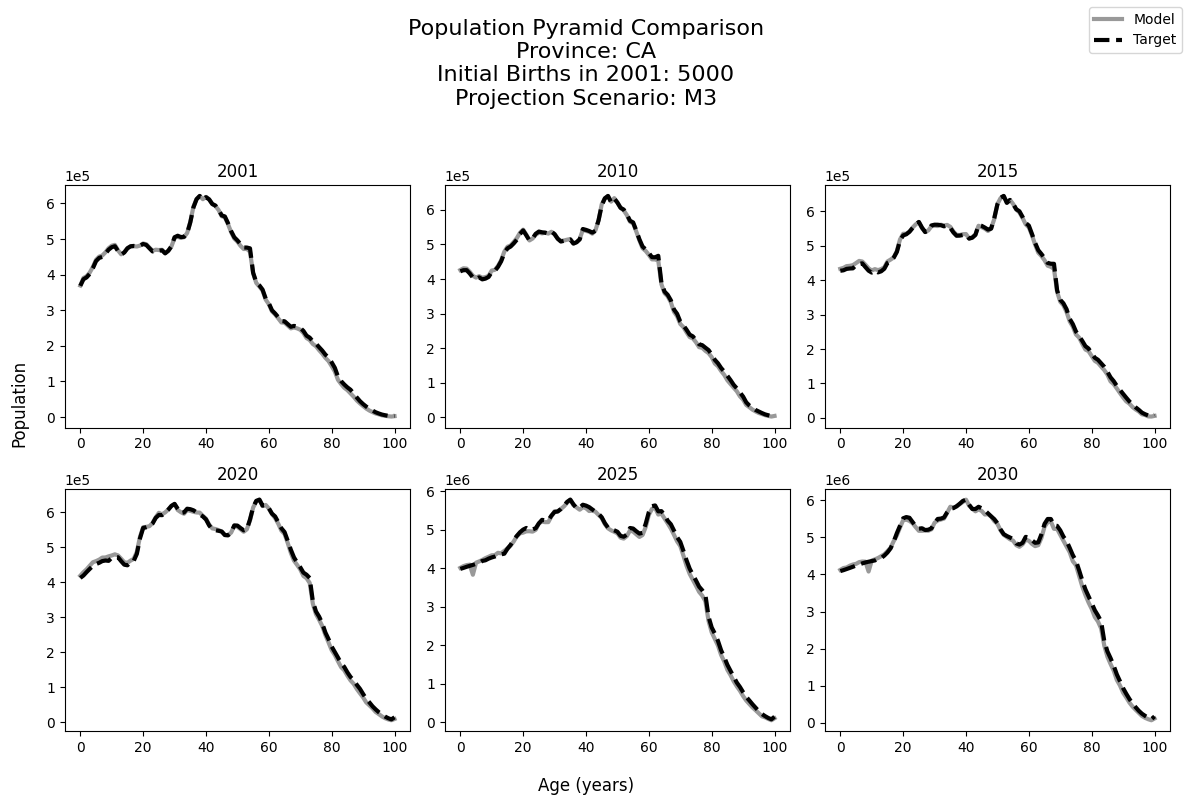

In [12]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 4 * num_rows))

# Loop over figure years to make one plot per year
for i, sex in enumerate(figure_years):
    # Get axis for current plot by indexing with i
    if num_rows == 1:
        if num_cols == 1:
            ax: plt.Axes = axs
        else:
            ax: plt.Axes = axs[i % num_cols]
    else:
        ax: plt.Axes = axs[i // num_cols][i % num_cols]

    # Filter by current year
    fig5_filtered_df = population_df[population_df["year"] == sex]
    # Group by age and sum over sexes to current number of population for each age
    fig5_filtered_df = fig5_filtered_df.groupby("age").sum().reset_index()

    # Scale the simulation data to match the maximum population of the stats data
    max_stats_age = fig5_filtered_df["n_alive_target"].max()
    max_simulation_age = fig5_filtered_df["n_alive_model"].max()
    scaling_factor = max_stats_age / max_simulation_age
    fig5_filtered_df["n_alive_model"] *= scaling_factor

    # Plot age trend from model
    ax.plot(
        fig5_filtered_df["age"],
        fig5_filtered_df["n_alive_model"],
        color="#999999",
        linestyle="-",
        linewidth=3,
        label="simulated",
    )
    # Plot age trend from target
    ax.plot(
        fig5_filtered_df["age"],
        fig5_filtered_df["n_alive_target"],
        color="black",
        linestyle="dashed",
        linewidth=3,
        label="observed",
    )

    # Title and Labels
    ax.set_title(f"{sex}", fontsize=12)
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

# Additional labels
fig.supxlabel("Age (years)")
fig.supylabel("Population")
fig.suptitle(
    f"Population Pyramid Comparison\n"
    + f"Province: {PROVINCE}\n"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"
    + f"Projection Scenario: {GROWTH_TYPE}",
    fontsize=16,
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0.01, 0, 1, 0.95])


plt.show()

## Infant Antibiotic Exposure Figure

Rate of infant antibiotic prescriptions by sex (red: females; blue: males) for simulated
(solid) and target (dotted) values from the model and the population-based administrative
database, respectively, with the floor rate of 50 per 1,000 (purple).

### Load Data

In [13]:
# Load antibiotic data from StatsCanada
target_abx_df = pd.read_csv(DATA_FOLDER / "InfantAbxBC.csv")

# Load antibiotic data from simulation
model_abx_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_antibiotic_exposure.csv")

# Load additional simulation data for population comparisson
model_infant_alive_df_raw =pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")
model_infant_death_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")
model_infant_emigration_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_emigration.csv")

### Process Data

In [14]:
# Merge all datasets on Year, Sex, and Age
model_abx_df = model_abx_df_raw.rename(columns={'n_antibiotic_exposure': 'n'}).merge(
    model_infant_alive_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_death_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_emigration_df_raw, on=['year', 'sex', 'age']
)

# Filter for age 0
model_abx_df = model_abx_df[model_abx_df['age'] == 0].copy()

# Compute total population (N) and rate per 1,000
model_abx_df["N"] = model_abx_df["n_alive"] + model_abx_df["n_deaths"] + model_abx_df["n_emigrants"]
model_abx_df["rate"] = (model_abx_df["n"] / model_abx_df["N"]) * 1000

# Map sex values for labeling
model_abx_df["sex"] = model_abx_df["sex"].map({"F": "Female", "M": "Male"})

### Visualize Data

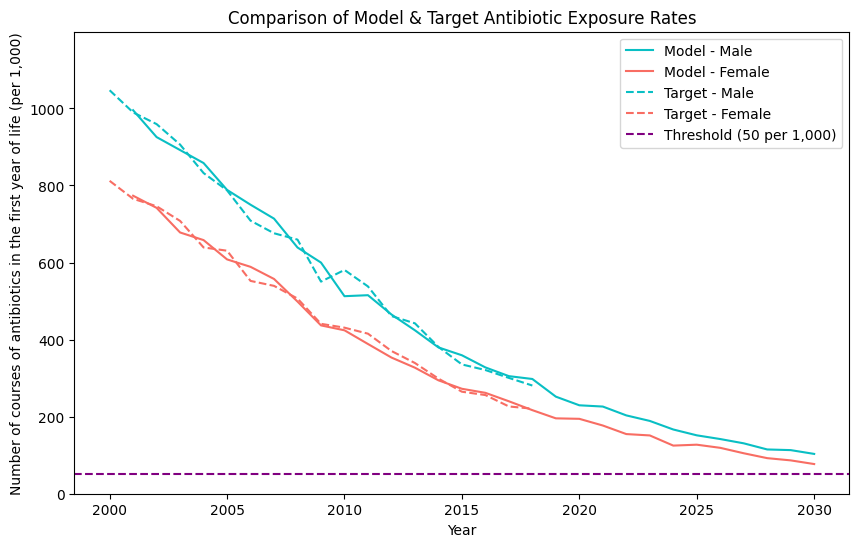

In [15]:
# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}


plt.figure(figsize=(10, 6))

# Plot inftant abx data from simulation
for gender in ["Male", "Female"]:
    subset = model_abx_df[model_abx_df["sex"] == gender]
    plt.plot(subset["year"], subset["rate"],
             label=f"Model - {gender}", color=sex_colour_dict[gender])

# Plot target infant abx data
for gender in ["Male", "Female"]:
    subset = target_abx_df[target_abx_df["sex"] == gender]
    plt.plot(subset["year"], subset["rate"], linestyle="dashed",
             label=f"Target - {gender}", color=sex_colour_dict[gender])

# Add horizontal reference line
plt.axhline(y=50, color="purple", linestyle="dashed", label="Threshold (50 per 1,000)")

# Labels, legend, and formatting
plt.xlabel("Year")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1,000)")
plt.ylim(0, 1199)
plt.legend()
plt.title("Comparison of Model & Target Antibiotic Exposure Rates")

plt.show()

## Control Level Figure

Asthma control levels (red: well-controlled; green: partially controlled; blue: uncontrolled) by the model (solid) and target (dashed).

### Load Data

In [16]:
# Read in simulation control data
model_exac_severity_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_control.csv")

### Process Data

In [17]:
# Validation parameters
TARGET_WC = 0.35
TARGET_PC = 0.47
TARGET_UC = 0.18

# Filter by levels
model_exac_level0_df = model_exac_severity_df_raw[model_exac_severity_df_raw["level"] == 0]  # UC
model_exac_level1_df = model_exac_severity_df_raw[model_exac_severity_df_raw["level"] == 1]  # PC
model_exac_level2_df = model_exac_severity_df_raw[model_exac_severity_df_raw["level"] == 2]  # WC

# Sum over sexes and years
model_exac_level0_total = model_exac_level0_df.groupby(["year"])["prob"].sum().reset_index()
model_exac_level1_total = model_exac_level1_df.groupby(["year"])["prob"].sum().reset_index()
model_exac_level2_total = model_exac_level2_df.groupby(["year"])["prob"].sum().reset_index()

# Normalize over 3 levels
for sex in model_exac_level0_total["year"].unique():
    p0 = model_exac_level0_total.loc[model_exac_level0_total["year"] == sex, "prob"].values
    p1 = model_exac_level1_total.loc[model_exac_level1_total["year"] == sex, "prob"].values
    p2 = model_exac_level2_total.loc[model_exac_level2_total["year"] == sex, "prob"].values
    total = p0 + p1 + p2
    model_exac_level0_total.loc[model_exac_level0_total["year"] == sex, "prob"] /= total
    model_exac_level1_total.loc[model_exac_level1_total["year"] == sex, "prob"] /= total
    model_exac_level2_total.loc[model_exac_level2_total["year"] == sex, "prob"] /= total

### Visualize Data

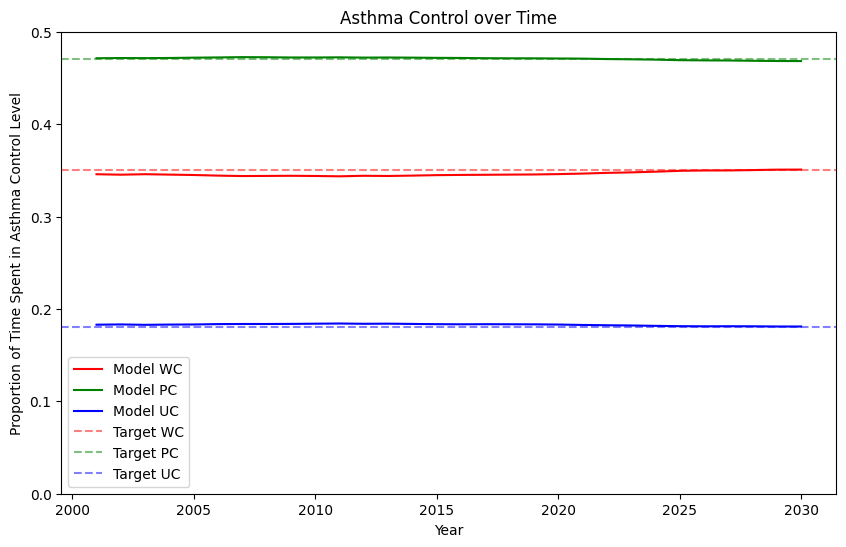

In [18]:
# Plotting parameters
plt.figure(figsize=(10, 6))

# Plot well-controlled from model
plt.plot(
    model_exac_level0_total["year"],
    model_exac_level0_total["prob"],
    label="Model WC",
    color="red",
    linestyle="solid",
)
# Plot partially-controlled from model
plt.plot(
    model_exac_level1_total["year"],
    model_exac_level1_total["prob"],
    label="Model PC",
    color="green",
    linestyle="solid",
)
# Plot uncontrolled from model
plt.plot(
    model_exac_level2_total["year"],
    model_exac_level2_total["prob"],
    label="Model UC",
    color="blue",
    linestyle="solid",
)
# Plot horizontal target values
plt.axhline(y=TARGET_WC, label="Target WC", color="red", linestyle="dashed", alpha=0.5)
plt.axhline(y=TARGET_PC, label="Target PC", color="green", linestyle="dashed", alpha=0.5)
plt.axhline(y=TARGET_UC, label="Target UC", color="blue", linestyle="dashed", alpha=0.5)

# Additional elements
plt.ylim(0, 0.5)
plt.xlabel("Year")
plt.ylabel("Proportion of Time Spent in Asthma Control Level")
plt.title("Asthma Control over Time")
plt.legend()

plt.show()

## Asthma Exacerbation Severity Figure

Simulated (solid) and target (dotted) asthma exacerbation severity levels
(red: mild; blue: moderate; green: severe; purple: very severe).

### Load Data

In [19]:
# Read in simulation control data
model_exac_severity_df_raw = pd.read_csv(
    RUN_BUNDLE_FOLDER / "outcome_matrix_exacerbation_by_severity.csv"
)

### Process Data

In [20]:
# Validation parameters
TARGET_MILD = 0.495
TARGET_MODERATE = 0.195
TARGET_SEVERE = 0.283
TARGET_VERY_SEVERE = 0.026

# Filter by levels
# mild
model_exac_level0_df = model_exac_severity_df_raw[model_exac_severity_df_raw["severity"] == 0]
# moderate
model_exac_level1_df = model_exac_severity_df_raw[model_exac_severity_df_raw["severity"] == 1]
# severe
model_exac_level2_df = model_exac_severity_df_raw[model_exac_severity_df_raw["severity"] == 2]
# very severe
model_exac_level3_df = model_exac_severity_df_raw[model_exac_severity_df_raw["severity"] == 3]

# Sum over sexes and years
model_exac_level0_total = (
    model_exac_level0_df.groupby(["year"])["p_exacerbations"].sum().reset_index()
)
model_exac_level1_total = (
    model_exac_level1_df.groupby(["year"])["p_exacerbations"].sum().reset_index()
)
model_exac_level2_total = (
    model_exac_level2_df.groupby(["year"])["p_exacerbations"].sum().reset_index()
)
model_exac_level3_total = (
    model_exac_level3_df.groupby(["year"])["p_exacerbations"].sum().reset_index()
)

# Normalize over 4 severities
for sex in model_exac_level0_total["year"].unique():
    p0 = model_exac_level0_total.loc[
        model_exac_level0_total["year"] == sex, "p_exacerbations"
    ].values
    p1 = model_exac_level1_total.loc[
        model_exac_level1_total["year"] == sex, "p_exacerbations"
    ].values
    p2 = model_exac_level2_total.loc[
        model_exac_level2_total["year"] == sex, "p_exacerbations"
    ].values
    p3 = model_exac_level3_total.loc[
        model_exac_level3_total["year"] == sex, "p_exacerbations"
    ].values
    total = p0 + p1 + p2 + p3
    model_exac_level0_total.loc[model_exac_level0_total["year"] == sex, "p_exacerbations"] /= total
    model_exac_level1_total.loc[model_exac_level1_total["year"] == sex, "p_exacerbations"] /= total
    model_exac_level2_total.loc[model_exac_level2_total["year"] == sex, "p_exacerbations"] /= total
    model_exac_level3_total.loc[model_exac_level3_total["year"] == sex, "p_exacerbations"] /= total

### Visualize Data

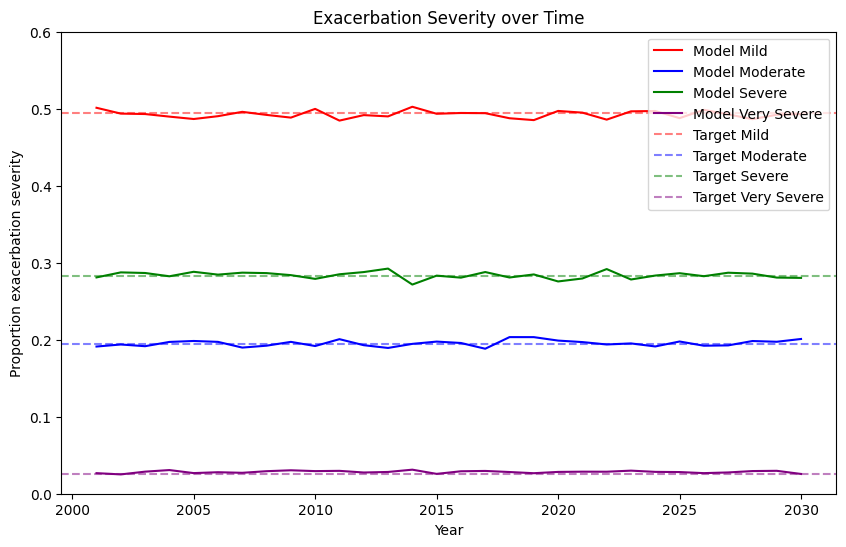

In [21]:
# Plotting parameters
plt.figure(figsize=(10, 6))

# Create plots for each severity level
# Plot mild exacerbation severity from model
plt.plot(
    model_exac_level0_total["year"],
    model_exac_level0_total["p_exacerbations"],
    label="Model Mild",
    color="red",
    linestyle="solid",
)
# Plot moderate  exacerbation severity from model
plt.plot(
    model_exac_level1_total["year"],
    model_exac_level1_total["p_exacerbations"],
    label="Model Moderate",
    color="blue",
    linestyle="solid",
)
# Plot severe exacerbation severity from model
plt.plot(
    model_exac_level2_total["year"],
    model_exac_level2_total["p_exacerbations"],
    label="Model Severe",
    color="green",
    linestyle="solid",
)
# Plot very severe exacerbation severity from model
plt.plot(
    model_exac_level3_total["year"],
    model_exac_level3_total["p_exacerbations"],
    label="Model Very Severe",
    color="purple",
    linestyle="solid",
)
# Plot horizontal target values
plt.axhline(y=TARGET_MILD, label="Target Mild", color="red", linestyle="dashed", alpha=0.5)
plt.axhline(y=TARGET_MODERATE, label="Target Moderate", color="blue", linestyle="dashed", alpha=0.5)
plt.axhline(y=TARGET_SEVERE, label="Target Severe", color="green", linestyle="dashed", alpha=0.5)
plt.axhline(
    y=TARGET_VERY_SEVERE, label="Target Very Severe", color="purple", linestyle="dashed", alpha=0.5
)

# Additional elements
plt.ylim(0, 0.6)
plt.xlabel("Year")
plt.ylabel("Proportion exacerbation severity")
plt.title("Exacerbation Severity over Time")
plt.legend(loc="upper right")

plt.show()

## Very Severe (Hospitalizations) Figure

Comparison of simulated (grey solid) and target (black dotted) very severe asthma
exacerbations (asthma-related hospital admissions) per 100,000 general population by sex (left:
females; right: males) across years.

### Load Data

In [22]:
# Load in hospitalization from target (CIHI)
target_hosp_df_raw = pd.read_csv(
    LEAP_ROOT / "leap" / "original_data" / "asthma_hosp" / PROVINCE / "tab1_rate.csv"
)
target_hosp_N_df_raw = pd.read_csv(
    LEAP_ROOT / "leap" / "original_data" / "asthma_hosp" / PROVINCE / "tab1_N.csv"
)

# Load hospitalization data from simulation
model_hosp_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_exacerbation_hospital.csv")

### Process Data

In [73]:
# Change target data from wide format to long format
target_id_vars = ["fiscal_year"]
target_value_vars = [col for col in target_hosp_df_raw.columns if col not in target_id_vars]
target_hosp_long_df = target_hosp_df_raw.melt(
    id_vars="fiscal_year", var_name="type", value_name="rate"
)
target_hosp_N_long_df = target_hosp_N_df_raw.melt(
    id_vars="fiscal_year", var_name="type", value_name="N_tot"
)

# Merge target hospitalization data sets
target_hosp_df = target_hosp_long_df.merge(target_hosp_N_long_df, on=["fiscal_year", "type"])

# Parse sex and age from 'type' column
target_hosp_df["sex"] = (
    target_hosp_df["type"].str[0].apply(lambda s: s if s in ["M", "F"] else None)
)
target_hosp_df["age"] = target_hosp_df["type"].str.extract(r"(\d+)").astype(float)

# Drop missing or non-positive rows
target_hosp_df = target_hosp_df.dropna(subset=["rate", "N_tot"])

# Rename fiscal_year to match model
target_hosp_df = target_hosp_df.rename(columns={"fiscal_year": "year"})

# Filter fo years larger than starting year
target_hosp_df = target_hosp_df[target_hosp_df["year"] >= STARTING_YEAR]

# Compute true rate
target_hosp_total_df = (
    target_hosp_df.groupby(["year", "sex"])
    .apply(
        lambda g: (g["rate"] * g["N_tot"]).sum() / (g["N_tot"].sum()),
        include_groups=False,
    )
    .reset_index(name="true_rate")
)


# Get total population in model for current year, age, sex
model_hosp_df = model_hosp_df_raw.merge(model_alive_df_raw, on=["year", "age", "sex"])

# Group columns to get some
model_hosp_df = model_hosp_df.groupby(["year", "sex"]).sum().reset_index()

# Compute rate per 100,000
model_hosp_df["h_rate"] = model_hosp_df["n_hospitalizations"] / model_hosp_df["n_alive"] * 100000

### Visualize Data

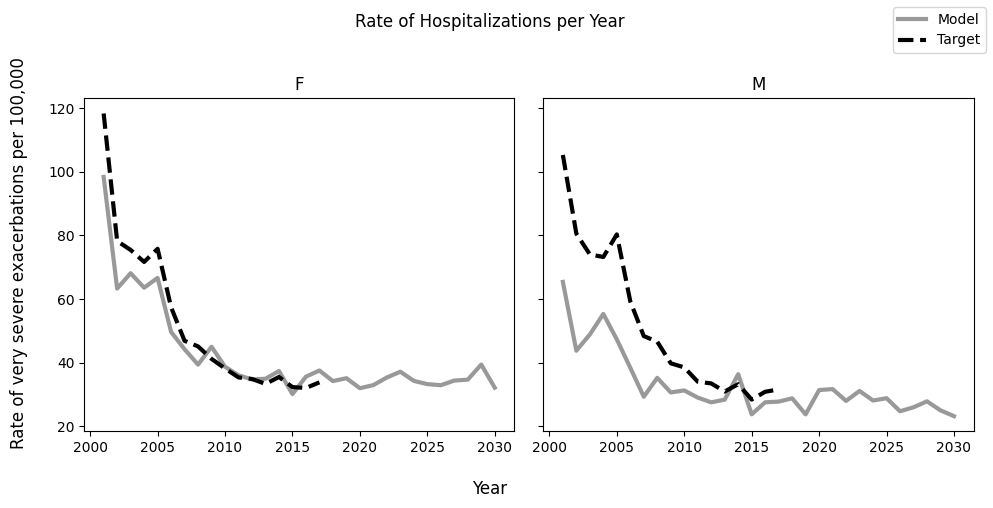

In [74]:
num_cols = 2
num_rows = 1
figure_sexes = ["F", "M"]
fig, axs = plt.subplots(
    nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True
)

# Loop over figure sexes to make one plot per sex
for i, sex in enumerate(figure_sexes):
    # Select correct axis
    ax = axs[i]

    # Filter by sex for model and target
    model_hosp_filtered_df = model_hosp_df[model_hosp_df["sex"] == sex]
    target_hosp_filtered_df = target_hosp_total_df[target_hosp_total_df["sex"] == sex]
    

    # Plot model data
    ax.plot(
        model_hosp_filtered_df["year"],
        model_hosp_filtered_df["h_rate"],
        color="#999999",
        linestyle="-",
        linewidth=3,
        label="Model",
    )
    # Plot target data
    ax.plot(
        target_hosp_filtered_df["year"],
        target_hosp_filtered_df["true_rate"],
        color="black",
        linestyle="dashed",
        linewidth=3,
        label="Target",
    )

    # Title and Labels
    ax.set_title(f"{sex}", fontsize=12)


# Additional labels
fig.supxlabel("Year")
fig.supylabel("Rate of very severe exacerbations per 100,000")
fig.suptitle("Rate of Hospitalizations per Year")
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0.01, 0, 1, 0.95])

plt.show()